In [8]:
%matplotlib inline

In [9]:
from keras.layers.core import Dense, MaxoutDense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn import cross_validation
from sklearn.metrics import auc, roc_curve
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [10]:
max_n_s = 10000

X = []
Y = []

with h5py.File('wprime_images_rs.h5', 'r') as infile:
    n_s    = min(len(infile['images']['image']), max_n_s)
    images = infile['images']['image'][:n_s]
    images = images.reshape(-1, images.shape[1] * images.shape[2])
    X.append(images)
    Y.append(np.repeat([[1, 0]], images.shape[0], axis=0))
with h5py.File('qcd_images_rs.h5', 'r') as infile:
    n_s    = min(len(infile['images']['image']), max_n_s)
    images = infile['images']['image'][:n_s]
    images = images.reshape(-1, images.shape[1] * images.shape[2])
    X.append(images)
    Y.append(np.repeat([[0, 1]], images.shape[0], axis=0))

X = np.concatenate(X)
Y = np.concatenate(Y)

In [11]:
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=0.1)

In [12]:
epochs     = 100
patience   = 10
batch_size = 32

model = Sequential()
model.add(MaxoutDense(input_shape=(625,), output_dim=256, nb_feature=5, init='he_uniform'))
model.add(MaxoutDense(output_dim=128, nb_feature=5))
model.add(Dense(output_dim=64, activation='relu'))
model.add(Dense(output_dim=25, activation='relu'))
model.add(Dense(output_dim=2, activation='sigmoid'))
optimizer = Adam()

In [13]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
X_fit, X_val, Y_fit, Y_val = cross_validation.train_test_split(X_train, Y_train, test_size=0.1)
best_auc = 0.
stop_cdn = 0
res      = 1.0/max_n_s

for epoch in range(epochs):
    model.fit(X_fit, Y_fit, nb_epoch=1, batch_size=batch_size,
              validation_split=0.1, verbose=0)
    
    Y_pred  = model.predict_proba(X_val, batch_size=batch_size, verbose=0)
    Y_pred /= Y_pred.sum(axis=1)[:,np.newaxis]
    fpr, tpr, thresholds = roc_curve(Y_val[:,0], Y_pred[:,0])
    inv_curve = np.array([ [tp, 1./max(fp,res)]
        for tp,fp in zip(tpr,fpr) if (0.2 <= tp <= 0.8 and fp > 0.) ])
    current_auc = auc(inv_curve[:,0], inv_curve[:,1])
    
    if current_auc > best_auc:
        best_auc = current_auc
        stop_cdn = 0
        model.save_weights("best_model.h5", overwrite=True)
    else:
        stop_cdn += 1
    
    print "Epoch {0}/{1}:".format(epoch+1, epochs)
    print "AUC                 = {0}".format(current_auc)
    print "Epochs w/o increase = {0}".format(stop_cdn)
    
    if stop_cdn >= patience:
        print "Patience tolerance reached"
        break

print "Training complete"

Epoch 1/100:
AUC                 = 9.08048886484
Epochs w/o increase = 0
Epoch 2/100:
AUC                 = 24.8003596744
Epochs w/o increase = 0
Epoch 3/100:
AUC                 = 35.7967822427
Epochs w/o increase = 0
Epoch 4/100:
AUC                 = 34.8705767017
Epochs w/o increase = 1
Epoch 5/100:
AUC                 = 35.9627369486
Epochs w/o increase = 0
Epoch 6/100:
AUC                 = 37.6600990557
Epochs w/o increase = 0
Epoch 7/100:
AUC                 = 36.3997210871
Epochs w/o increase = 1
Epoch 8/100:
AUC                 = 38.9366333886
Epochs w/o increase = 0
Epoch 9/100:
AUC                 = 35.7811017753
Epochs w/o increase = 1
Epoch 10/100:
AUC                 = 37.7964960261
Epochs w/o increase = 2
Epoch 11/100:
AUC                 = 40.6976655814
Epochs w/o increase = 0
Epoch 12/100:
AUC                 = 40.0978713614
Epochs w/o increase = 1
Epoch 13/100:
AUC                 = 39.5447473661
Epochs w/o increase = 2
Epoch 14/100:
AUC                 = 41.33109651

In [14]:
model.load_weights("best_model.h5")
objective_score = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)
Y_pred  = model.predict_proba(X_test, batch_size=batch_size, verbose=0)
Y_pred /= Y_pred.sum(axis=1)[:,np.newaxis]
fpr, tpr, thresholds = roc_curve(Y_test[:,0], Y_pred[:,0])
inv_curve = np.array([ [tp, 1.0/max(fp,res)]
    for tp,fp in zip(tpr,fpr) if 0.2 <= tp <= 0.8 ])
final_auc = auc(inv_curve[:,0], inv_curve[:,1])
classes   = model.predict_classes(X_test, batch_size=batch_size, verbose=0)
accuracy  = [1 for i in range(len(Y_test)) if Y_test[i,classes[i]] == 1.0]

print "Score    = {0}".format(objective_score)
print "AUC      = {0}".format(final_auc)
print "Accuracy = {0}/{1} = {2}".format(
    sum(accuracy), len(Y_test), float(sum(accuracy)) / len(Y_test) )

Score    = 0.362912439108
AUC      = 55.8418316591
Accuracy = 1706/2000 = 0.853


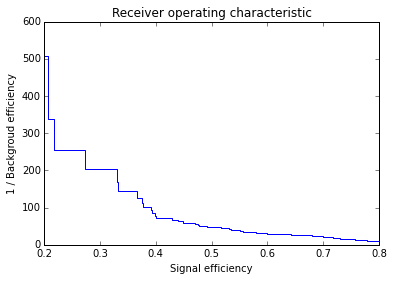

In [15]:
plt.figure()
plt.plot(inv_curve[:,0], inv_curve[:,1])
plt.xlabel("Signal efficiency")
plt.ylabel("1 / Backgroud efficiency")
plt.title("Receiver operating characteristic")
plt.show()